In [22]:
print(np.linspace(0, 93, 4))

[ 0. 31. 62. 93.]


shape: (277, 29376)


C:\Users\cuden\AppData\Local\Temp\ipykernel_12580\591044138.py:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ma == []:


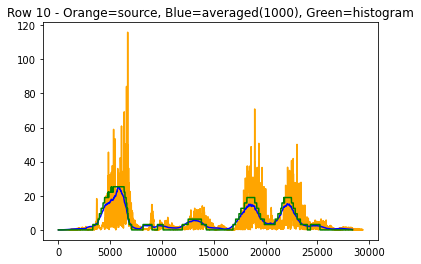

In [104]:
import numpy as np
from scipy.io import wavfile
from ssqueezepy import ssq_cwt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import sys

def scaler(array, min_, max_):
    array = array.reshape((-1, 1))
    scaler = MinMaxScaler(feature_range=(min_, max_))
    s_data = scaler.fit_transform(array)
    s_data = np.squeeze(s_data)
    return s_data

# Get wavelet from .wav file
def wav_to_wavelet(path):
    '''
    path: Direction to .wav file
    '''
    sample_rate, x = wavfile.read(path) 
    twx, wx, *_ = ssq_cwt(x)  # use wx
    print(f'shape: {wx.shape}')
    return np.abs(wx)

# Moving average function
def moving_average(array, window):
    '''
    array: short array have window length
    window: predefine value
    '''
    ret = np.cumsum(array, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window

# Moving average for wavelet
def wavelet_to_moving_average(matrix, window):
    '''
    matrix: a set of short array
    window: predefine value
    '''
    ma = []
    for i in matrix:
        i = moving_average(i, window)
        i = np.expand_dims(i, axis=0)
        if ma == []:
            ma = i
        else:
            ma = np.concatenate((ma, i), axis=0)
    return ma


def stairway(ma_row, bins, max_excursion):
    '''
    value: wavelet
    max_excursion: highest chosen value in stairway
    steps: number of bins
    '''
    range_ = np.linspace(0, max_excursion, bins).tolist()
    min_ma = np.min(ma_row)
    max_ma = np.max(ma_row)
    
    if max_ma > range_[-1]:
        range_[-1] = max_ma
    pair_ = [range_[i:i+2] for i in range(bins-1)]

    ma_hist = []
    for va in ma_row:
        for each_pair in pair_:
            if each_pair[0] < va < each_pair[1]:
                ma_hist.append(pair_.index(each_pair))
    
    ma_hist = np.array(ma_hist)
    ma_hist = ma_hist.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(min_ma, max_ma))
    ma_hist = scaler.fit_transform(ma_hist)
    ma_hist = ma_hist.reshape(-1, )
    return ma_hist    

# Plot a chosen row in the matrix
def plot_row(row, ax, c, matrix=None, option=None, hist=None, width=None):
    if np.max(matrix) != None:
        get = matrix[row]

    if np.max(hist) != None:
        # ax.bar(hist, hist, color=c, width=width)
        ax.plot(hist, c=c)
    else:
        ax.plot(get, c=c)



# parameters -----------------------------------------------------------
wav_file = 'wav/apple_and_lemmon.wav'
row = 10
window = 1000
max_excursion = 20
bins = 10

# computing part -------------------------------------------------------
wavelet = wav_to_wavelet(wav_file)
ma = wavelet_to_moving_average(wavelet, window)
ma_hist = stairway(ma[row], bins, max_excursion)

# Plot part -------------------------------------------------------------
fig = plt.figure()  
ax = fig.add_subplot()
plot_row(row, ax, 'orange', matrix=wavelet)
plot_row(row, ax, 'b', matrix=ma)
plot_row(row, ax, 'g', hist=ma_hist, width=0.4)

ax.set_title(f'Row {row} - Orange=source, Blue=averaged({window}), Green=histogram')
plt.show()
